In [2]:
%load_ext autoreload
%autoreload 2

import logging

import matplotlib.pyplot as plt

import defi.tulip.implementation.order as dtuimord
import defi.tulip.implementation.supply_demand as dtimsude
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint

In [3]:
try:
    import pulp
except ImportError:
    !sudo /bin/bash -c "(source /venv/bin/activate; pip install pulp)"
    pass
import defi.tulip.implementation.optimize as dtuimopt

In [4]:
hdbg.init_logger(verbosity=logging.DEBUG)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-c0b85203-29ef-461d-a1ee-16683baefe50.json'
DEBUG Effective logging level=10
DEBUG Shut up 28 modules: matplotlib.dates, matplotlib.style, matplotlib.pyplot, matplotlib.axes, matplotlib.ticker, matplotlib.textpath, matplotlib._constrained_layout, matplotlib.image, matplotlib.text, matplotlib.axes._axes, matplotlib._afm, matplotlib.mathtext, matplotlib.backend_bases, matplotlib.gridspec, matplotlib.colorbar, matplotlib.artist, matplotlib.style.core, matplotlib.lines, matplotlib, matplotlib.texmanager, matplotlib.figure, matplotlib._layoutgrid, matplotlib.dviread, matplotlib.axis, asyncio, matplotlib.axes._base, matplotlib.font_manager, matplotlib.category
DEBUG > (cd . && cd "$(git rev-parse --show-toplevel)/.." && (git rev-parse --is-inside-work-tree | grep -q true)) 2>&1
DEBUG > (git rev-parse --show-toplevel) 2>&1
-----------------------------------------------------------

# Get aggregated supply / demand

In [5]:
type_ = "supply"
alpha = 2.0
beta = 10.0
n_orders = 10
agg_supply_curve = dtimsude.get_supply_demand_aggregated_curve(
    type_, alpha, beta, n_orders
)
agg_supply_curve

ETH
2.501076      15.002151
2.979722      15.959444
8.693883      27.387767
22.321074     54.642148
27.502932     65.005864
42.192182     94.384364
63.942680    137.885360
67.669949    145.339897
73.647121    157.294243
89.217957    188.435914
Name: BTC.supply, dtype: float64

In [6]:
type_ = "demand"
alpha = -2.0
beta = 210.0
n_orders = 10
agg_demand_curve = dtimsude.get_supply_demand_aggregated_curve(
    type_, alpha, beta, n_orders
)
agg_demand_curve

ETH
2.626129     204.747741
3.128708     203.742584
9.128577     191.742845
23.437128    163.125745
28.878078    152.243843
44.301791    121.396418
67.139814     75.720372
71.053446     67.893108
77.329477     55.341045
93.678855     22.642291
Name: BTC.demand, dtype: float64

In [7]:
agg_supply_orders = dtimsude.convert_aggregated_curve_to_limit_orders(
    agg_supply_curve
)
agg_supply_orders_df = dtuimord.convert_orders_to_dataframe(agg_supply_orders)
agg_supply_orders_df

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-05-31 20:24:55.646008+00:00,sell,2.501076,BTC,15.002151,ETH,2
1,2023-05-31 20:24:55.646107+00:00,sell,0.478646,BTC,15.959444,ETH,1
2,2023-05-31 20:24:55.646120+00:00,sell,5.714161,BTC,27.387767,ETH,5
3,2023-05-31 20:24:55.646129+00:00,sell,13.627191,BTC,54.642148,ETH,4
4,2023-05-31 20:24:55.646137+00:00,sell,5.181858,BTC,65.005864,ETH,4
5,2023-05-31 20:24:55.646146+00:00,sell,14.68925,BTC,94.384364,ETH,3
6,2023-05-31 20:24:55.646154+00:00,sell,21.750498,BTC,137.88536,ETH,2
7,2023-05-31 20:24:55.646162+00:00,sell,3.727269,BTC,145.339897,ETH,9
8,2023-05-31 20:24:55.646169+00:00,sell,5.977173,BTC,157.294243,ETH,2
9,2023-05-31 20:24:55.646176+00:00,sell,15.570835,BTC,188.435914,ETH,10


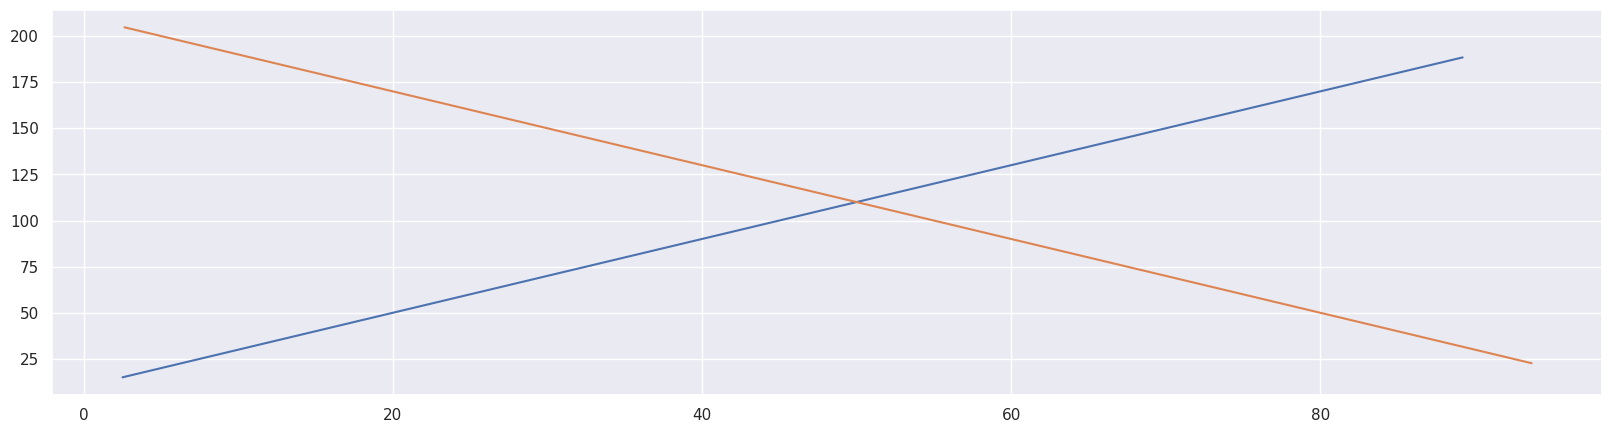

In [8]:
plt.plot(agg_supply_curve)
plt.plot(agg_demand_curve)
plt.show()

In [9]:
agg_demand_orders = dtimsude.convert_aggregated_curve_to_limit_orders(
    agg_demand_curve
)
agg_demand_orders_df = dtuimord.convert_orders_to_dataframe(agg_demand_orders)
agg_demand_orders_df

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address
0,2023-05-31 20:24:57.451580+00:00,buy,2.626129,BTC,204.747741,ETH,2
1,2023-05-31 20:24:57.451627+00:00,buy,0.502579,BTC,203.742584,ETH,1
2,2023-05-31 20:24:57.451638+00:00,buy,5.999869,BTC,191.742845,ETH,5
3,2023-05-31 20:24:57.451646+00:00,buy,14.30855,BTC,163.125745,ETH,4
4,2023-05-31 20:24:57.451653+00:00,buy,5.440951,BTC,152.243843,ETH,4
5,2023-05-31 20:24:57.451660+00:00,buy,15.423713,BTC,121.396418,ETH,3
6,2023-05-31 20:24:57.451667+00:00,buy,22.838023,BTC,75.720372,ETH,2
7,2023-05-31 20:24:57.451674+00:00,buy,3.913632,BTC,67.893108,ETH,9
8,2023-05-31 20:24:57.451681+00:00,buy,6.276031,BTC,55.341045,ETH,2
9,2023-05-31 20:24:57.451688+00:00,buy,16.349377,BTC,22.642291,ETH,10


# Implement DaoCross and DaoSwap

In [10]:
agg_all_orders = agg_supply_orders + agg_demand_orders
prices = {"BTC": 1, "ETH": 50}

In [11]:
daocross_results = dtuimopt.run_daocross_solver(agg_all_orders, prices)
display(daocross_results)

DEBUG orders=[timestamp=2023-05-31 20:24:55.646008+00:00 action=sell quantity=2.5010755222666936 base_token=BTC limit_price=15.002151044533388 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-05-31 20:24:55.646107+00:00 action=sell quantity=0.47864642154034076 base_token=BTC limit_price=15.959443887614068 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-05-31 20:24:55.646120+00:00 action=sell quantity=5.714161319134581 base_token=BTC limit_price=27.38776652588323 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-05-31 20:24:55.646129+00:00 action=sell quantity=13.62719055194066 base_token=BTC limit_price=54.64214762976455 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-31 20:24:55.646137+00:00 action=sell quantity=5.181858022029651 base_token=BTC limit_price=65.00586367382385 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-31 20:24:55.646146+00:00 action=sell quantity=14.689250131615118 bas

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-05-31 20:24:55.646008+00:00,sell,2.501076,BTC,15.002151,ETH,2,2.501075,125.053780,50.000002
1,2023-05-31 20:24:55.646107+00:00,sell,0.478646,BTC,15.959444,ETH,1,0.478646,23.932321,50.000000
2,2023-05-31 20:24:55.646120+00:00,sell,5.714161,BTC,27.387767,ETH,5,5.714161,285.708070,50.000001
3,2023-05-31 20:24:55.646129+00:00,sell,13.627191,BTC,54.642148,ETH,4,0.000000,0.000000,NaN
4,2023-05-31 20:24:55.646137+00:00,sell,5.181858,BTC,65.005864,ETH,4,0.000000,0.000000,NaN
5,2023-05-31 20:24:55.646146+00:00,sell,14.68925,BTC,94.384364,ETH,3,0.000000,0.000000,NaN
6,2023-05-31 20:24:55.646154+00:00,sell,21.750498,BTC,137.88536,ETH,2,0.000000,0.000000,NaN
7,2023-05-31 20:24:55.646162+00:00,sell,3.727269,BTC,145.339897,ETH,9,0.000000,0.000000,NaN
8,2023-05-31 20:24:55.646169+00:00,sell,5.977173,BTC,157.294243,ETH,2,0.000000,0.000000,NaN
9,2023-05-31 20:24:55.646176+00:00,sell,15.570835,BTC,188.435914,ETH,10,0.000000,0.000000,NaN


In [12]:
daoswap_results = dtuimopt.run_daoswap_solver(agg_all_orders)
display(daoswap_results)

DEBUG orders=[timestamp=2023-05-31 20:24:55.646008+00:00 action=sell quantity=2.5010755222666936 base_token=BTC limit_price=15.002151044533388 quote_token=ETH deposit_address=2 wallet_address=2, timestamp=2023-05-31 20:24:55.646107+00:00 action=sell quantity=0.47864642154034076 base_token=BTC limit_price=15.959443887614068 quote_token=ETH deposit_address=1 wallet_address=1, timestamp=2023-05-31 20:24:55.646120+00:00 action=sell quantity=5.714161319134581 base_token=BTC limit_price=27.38776652588323 quote_token=ETH deposit_address=5 wallet_address=5, timestamp=2023-05-31 20:24:55.646129+00:00 action=sell quantity=13.62719055194066 base_token=BTC limit_price=54.64214762976455 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-31 20:24:55.646137+00:00 action=sell quantity=5.181858022029651 base_token=BTC limit_price=65.00586367382385 quote_token=ETH deposit_address=4 wallet_address=4, timestamp=2023-05-31 20:24:55.646146+00:00 action=sell quantity=14.689250131615118 bas

,timestamp,action,quantity,base_token,limit_price,quote_token,deposit_address,q_pi_star,q_tau_star,effective_price
0,2023-05-31 20:24:55.646008+00:00,sell,2.501076,BTC,15.002151,ETH,2,2.501075,37.521513,15.002151
1,2023-05-31 20:24:55.646107+00:00,sell,0.478646,BTC,15.959444,ETH,1,0.478646,7.638931,15.959444
2,2023-05-31 20:24:55.646120+00:00,sell,5.714161,BTC,27.387767,ETH,5,5.714161,156.498120,27.387767
3,2023-05-31 20:24:55.646129+00:00,sell,13.627191,BTC,54.642148,ETH,4,13.627191,744.618960,54.642146
4,2023-05-31 20:24:55.646137+00:00,sell,5.181858,BTC,65.005864,ETH,4,5.181858,336.851160,65.005865
5,2023-05-31 20:24:55.646146+00:00,sell,14.68925,BTC,94.384364,ETH,3,14.689250,1386.435500,94.384363
6,2023-05-31 20:24:55.646154+00:00,sell,21.750498,BTC,137.88536,ETH,2,21.750498,2999.075200,137.885358
7,2023-05-31 20:24:55.646162+00:00,sell,3.727269,BTC,145.339897,ETH,9,3.727269,541.720880,145.339898
8,2023-05-31 20:24:55.646169+00:00,sell,5.977173,BTC,157.294243,ETH,2,5.977173,940.174850,157.294242
9,2023-05-31 20:24:55.646176+00:00,sell,15.570835,BTC,188.435914,ETH,10,11.663734,2197.866300,188.435907


# Sanity check with discrete supply / demand

In [13]:
type_ = "supply"
discrete_supply_curve = dtimsude.get_supply_demand_discrete_curve(
    type_, agg_supply_orders_df
)
discrete_supply_curve

ETH
2.501076      15.002151
2.979722      15.959444
8.693883      27.387767
22.321074     54.642148
27.502932     65.005864
42.192182     94.384364
63.942680     137.88536
67.669949    145.339897
73.647121    157.294243
89.217957    188.435914
Name: BTC.supply, dtype: Float64

In [14]:
type_ = "demand"
discrete_demand_curve = dtimsude.get_supply_demand_discrete_curve(
    type_, agg_demand_orders_df
)
discrete_demand_curve

ETH
2.626129     204.747741
3.128708     203.742584
9.128577     191.742845
23.437128    163.125745
28.878078    152.243843
44.301791    121.396418
67.139814     75.720372
71.053446     67.893108
77.329477     55.341045
93.678855     22.642291
Name: BTC.demand, dtype: Float64

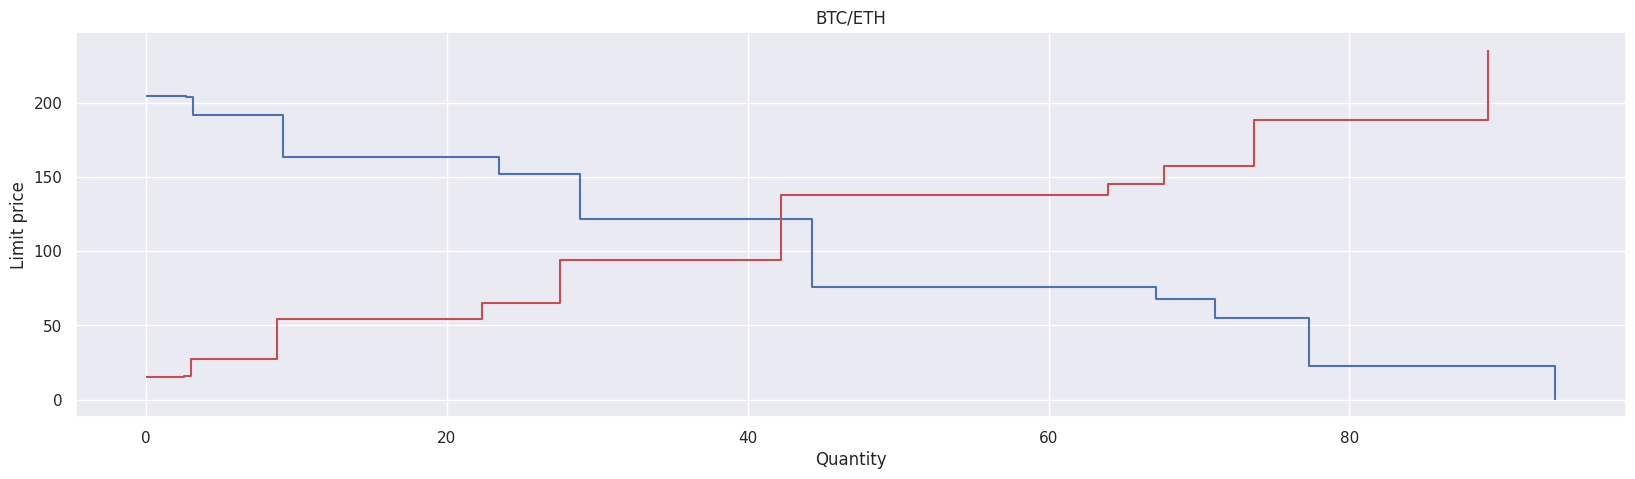

In [15]:
dtimsude.plot_discrete_curve(discrete_demand_curve)
dtimsude.plot_discrete_curve(discrete_supply_curve)
plt.show()